#### installation and import

In [55]:
!pip install wordcloud

In [ ]:
import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#### data load

In [ ]:
reviews = pd.read_csv('C:/Users/user/Desktop/BITAmin 15기/3_2025-夏/통계적머신러닝 프로젝트/olist_dataset/olist_order_reviews_dataset.csv')
reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [ ]:
reviews_mes = reviews[['review_score', 'review_comment_message']]
reviews_mes = reviews_mes.dropna(axis=0)
reviews_mes

,review_score,review_comment_message
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,aparelho eficiente. no site a marca do aparelh...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,"Vendedor confiável, produto ok e entrega antes..."
...,...,...
99205,4,para este produto recebi de acordo com a compr...
99208,5,Entregou dentro do prazo. O produto chegou em ...
99215,3,"O produto não foi enviado com NF, não existe v..."
99221,5,"Excelente mochila, entrega super rápida. Super..."


In [18]:
reviews_mes['review_score'].value_counts()

review_score
5    20554
1     8745
4     5976
3     3557
2     2145
Name: count, dtype: int64

In [ ]:
# 리뷰 점수를 카테고리화
def score_to_category(score):
    if score in [1, 2]:
        return "low"  # low: 1,2점
    elif score == 3:
        return "mid"  # mid: 3점
    elif score in [4, 5]:
        return "high"  # high: 4,5점
    else:
        return "unknown"

reviews_mes["score_category"] = reviews_mes["review_score"].apply(score_to_category)

#### review_comment_message(pt)를 기준으로 배송 지연 여부 분류

In [42]:
# 리뷰 데이터 준비
df = reviews_mes.copy()
texts = df["review_comment_message"].fillna("").tolist()

# mBERT 토크나이저 & 모델 로드
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# CPU 사용
device = torch.device("cpu")
model.to(device)
model.eval()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [43]:
# 리뷰 문장을 임베딩으로 변환 (pooling: [CLS] token)
def get_bert_embedding(text_list, batch_size=16):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt")
        with torch.no_grad():
            out = model(**enc.to(device))
        cls_emb = out.last_hidden_state[:,0,:].cpu().numpy()  # [CLS] token
        embeddings.append(cls_emb)
    return np.vstack(embeddings)

X_emb = get_bert_embedding(texts)

In [44]:
delay_keywords = [
    # 시간 관련
    "atrasado", "atraso", "demora", "demorou", "demorado", "tarde", "chegou tarde", "entrega atrasada", "adiantado", "cedo", "chegou atrasado", 

    # 상태/부정 표현
    "nao chegou", "não chegou", "problema", "problemático", "complicado", "não entregue", "não enviado", "perdeu", "extraviado", 

    # 속도/품질 반영
    "lento", "lentamente", "atrasou", "atrasando"
]

In [45]:
# 간단한 rule-based 라벨 생성 (delay = 1, normal = 0)
def label_delay(text):
    text_lower = str(text).lower()
    for kw in delay_keywords:
        if kw in text_lower:
            return 1
    return 0

In [46]:
y = df["review_comment_message"].apply(label_delay).values

In [ ]:
# LogisticRegression classifier 학습
clf = LogisticRegression(max_iter=1000)
clf.fit(X_emb, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
# 리뷰별 지연 예측
df["shipping_delay_pred"] = clf.predict(X_emb)
print(df[["review_comment_message", "shipping_delay_pred"]].head())

                               review_comment_message  shipping_delay_pred
3               Recebi bem antes do prazo estipulado.                    0
4   Parabéns lojas lannister adorei comprar pela I...                    0
9   aparelho eficiente. no site a marca do aparelh...                    0
12    Mas um pouco ,travando...pelo valor ta Boa.\r\n                    0
15  Vendedor confiável, produto ok e entrega antes...                    0


In [54]:
df['shipping_delay_pred'].value_counts()

shipping_delay_pred
0    39498
1     1479
Name: count, dtype: int64

In [65]:
df

,review_score,review_comment_message,score_category,shipping_issue,shipping_issue_en,shipping_delay_pred
3,5,Recebi bem antes do prazo estipulado.,high,prazo,deadline,0
4,5,Parabéns lojas lannister adorei comprar pela I...,high,seguro,safe,0
9,4,aparelho eficiente. no site a marca do aparelh...,high,eficiente,efficient,0
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",high,,,0
15,5,"Vendedor confiável, produto ok e entrega antes...",high,"entrega, prazo, confiável","delivery, deadline, reliable",0
...,...,...,...,...,...,...
99205,4,para este produto recebi de acordo com a compr...,high,,,0
99208,5,Entregou dentro do prazo. O produto chegou em ...,high,prazo,deadline,0
99215,3,"O produto não foi enviado com NF, não existe v...",mid,envio,shipping,0
99221,5,"Excelente mochila, entrega super rápida. Super...",high,entrega,delivery,0


In [66]:
df.to_csv('olist_delay_prediction.csv')

#### visulization

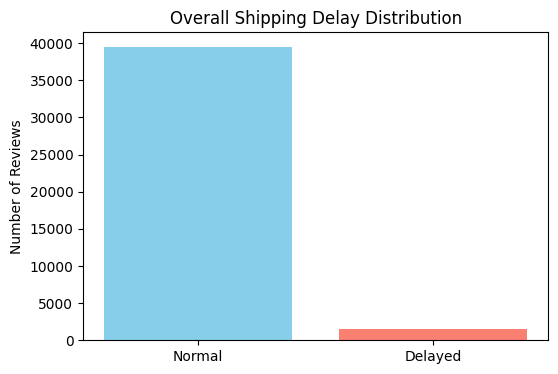

In [61]:
# 전체 배송 지연 비율

# 전체 리뷰에서 지연/정상 개수
counts = df["shipping_delay_pred"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(["Normal", "Delayed"], counts.values, color=["skyblue","salmon"])
plt.title("Overall Shipping Delay Distribution")
plt.ylabel("Number of Reviews")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_2668\2176712340.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delay_ratio.index, y=delay_ratio.values, palette="coolwarm")


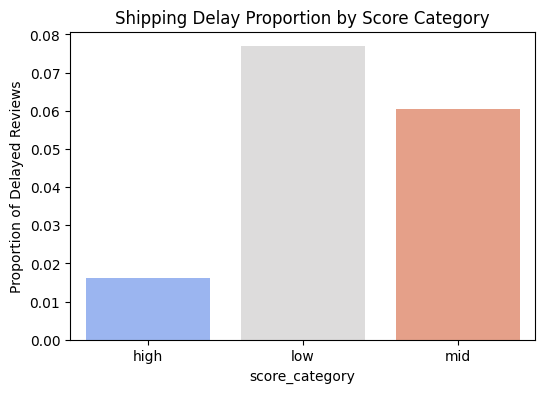

In [62]:
# 점수 카테고리별(low/mid/high) 지연 비율

# score_category별 지연 비율 계산
delay_ratio = df.groupby("score_category")["shipping_delay_pred"].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=delay_ratio.index, y=delay_ratio.values, palette="coolwarm")
plt.ylabel("Proportion of Delayed Reviews")
plt.title("Shipping Delay Proportion by Score Category")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_2668\4006227534.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delay_ratio_score.index, y=delay_ratio_score.values, palette="viridis")


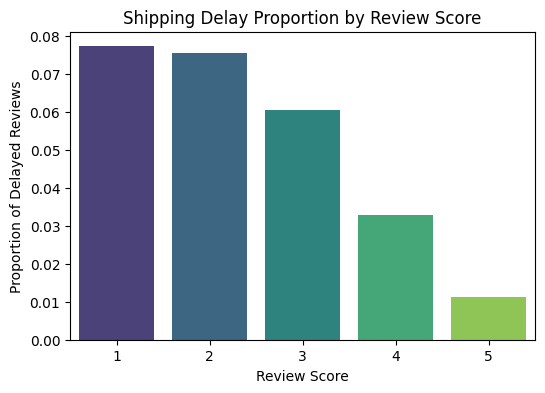

In [63]:
# 점수별(1~5점) 지연 비율

delay_ratio_score = df.groupby("review_score")["shipping_delay_pred"].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=delay_ratio_score.index, y=delay_ratio_score.values, palette="viridis")
plt.xlabel("Review Score")
plt.ylabel("Proportion of Delayed Reviews")
plt.title("Shipping Delay Proportion by Review Score")
plt.show()

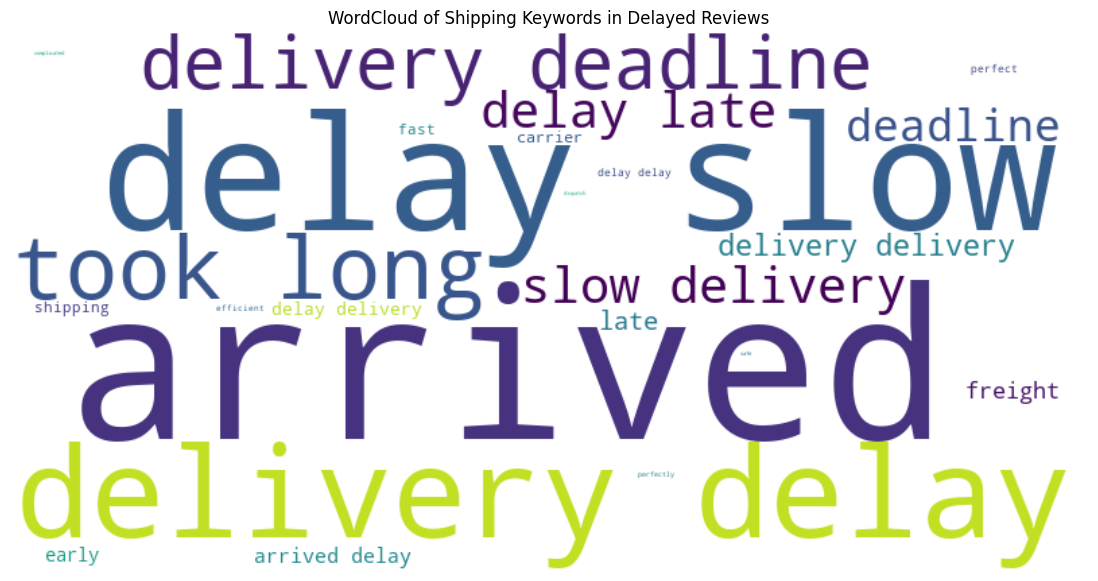

In [64]:
# 워드클라우드와 결합
# 지연 리뷰만 뽑아서 배송 키워드 WordCloud 생성

text_delay = ", ".join(df.loc[df["shipping_delay_pred"]==1, "shipping_issue_en"].dropna())
wc = WordCloud(width=800, height=400, background_color="white").generate(text_delay)

plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Shipping Keywords in Delayed Reviews")
plt.show()

In [ ]:
# 단순 단어 빈도 수 계산 (WordCloud 기반)

from collections import Counter

# 지연 리뷰에서 shipping_issue_en 컬럼 기준
texts_delay = df.loc[df["shipping_delay_pred"]==1, "shipping_issue_en"].dropna()

# 단어 나누기 (콤마 기준)
words = []
for t in texts_delay:
    words.extend([w.strip() for w in t.split(",")])

# 단어 빈도 계산
word_count = Counter(words)

# 상위 20개 단어 확인
top20 = word_count.most_common(20)
print(top20)

[('delivery', 478), ('', 451), ('not arrived', 414), ('delay', 355), ('slow', 208), ('deadline', 183), ('took long', 161), ('late', 133), ('freight', 33), ('early', 23), ('carrier', 19), ('fast', 17), ('shipping', 17), ('perfect', 8), ('efficient', 4), ('perfectly', 3), ('arrived late', 3), ('dispatch', 2), ('late delivery', 2), ('safe', 2)]


In [68]:
# 단어 비율로 확인

total = sum(word_count.values())
word_ratio = {w: c/total for w, c in word_count.items()}

# 상위 10개 단어 비율 확인
top10_ratio = dict(sorted(word_ratio.items(), key=lambda x: x[1], reverse=True)[:10])
print(top10_ratio)

{'delivery': 0.1893069306930693, '': 0.1786138613861386, 'not arrived': 0.16396039603960397, 'delay': 0.1405940594059406, 'slow': 0.08237623762376238, 'deadline': 0.07247524752475247, 'took long': 0.06376237623762376, 'late': 0.05267326732673267, 'freight': 0.013069306930693069, 'early': 0.009108910891089108}


C:\Users\user\AppData\Local\Temp\ipykernel_2668\104878097.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_words.keys()), y=list(top_words.values()), palette="viridis")


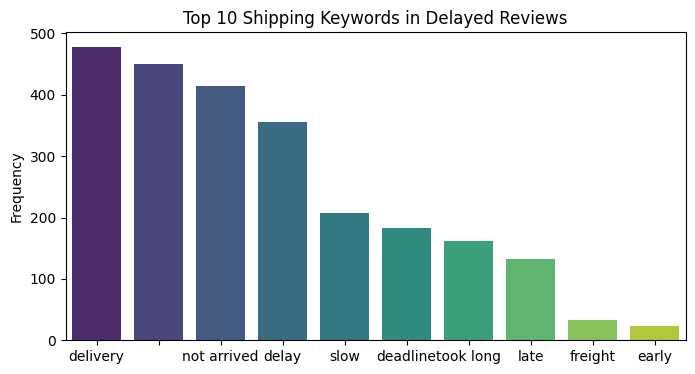

In [69]:
# 시각화와 결합

import matplotlib.pyplot as plt
import seaborn as sns

top_words = dict(word_count.most_common(10))

plt.figure(figsize=(8,4))
sns.barplot(x=list(top_words.keys()), y=list(top_words.values()), palette="viridis")
plt.title("Top 10 Shipping Keywords in Delayed Reviews")
plt.ylabel("Frequency")
plt.show()